In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import metpy.calc as mpcalc

from datetime import datetime

from metpy.plots import SkewT
from metpy.units import pandas_dataframe_to_unit_arrays, units

from siphon.simplewebservice.wyoming import WyomingUpperAir

### Set desired time period and station ID

In [2]:
# July 21, 2021 00Z
day_dt = datetime(2021, 7, 21, 0)

# July 21, 2021 12Z
night_dt = datetime(2021, 7, 21, 12)

# station ID of Laoag 
station = 'RPLI'

### Obtain sounding data for Laoag from University of Wyoming's website

In [3]:
# Read remote sounding data based on time (dt) and station
day_df = WyomingUpperAir.request_data(day_dt, station)
night_df = WyomingUpperAir.request_data(night_dt, station)

# Create dictionary of united arrays
day_data = pandas_dataframe_to_unit_arrays(day_df)
night_data = pandas_dataframe_to_unit_arrays(night_df)

### Extract necessary synoptic measurements from sounding data

In [4]:
# Isolate united arrays from dictionary to individual variables
p = day_data['pressure']
T = day_data['temperature']
Td = day_data['dewpoint']
u = day_data['u_wind']
v = day_data['v_wind']

## Meaning of diagram lines
- blue dashed line = mixing ratio lines
- diagonal gray lines = temperature
- orange dashed curve = dry adiabats
- green dashed curve = saturated adiabats

## Moisture/Humidity Measurements

- blue dashed lines = mixing ratio
    - saturation mixing ratio (ws) = read remperature (in red) line
    - mixing ratio (w) = read dewpoint temperature (in green) line
    - relative humidity (RH) = 100*(w/ws) 
- diagonal gray lines = temperature
    - dewpoint depression = temperature - dewpoint temperature
    - saturation vapor pressure = follow isotherm from temperature to 622 hPa isobar
    - vapor pressure = follow isotherm from dewpoint temperature to 622 hPa

## Temperature/Level Measurements

- Temperature
    - virtual temperature ~ T +(w/6)
    - potential temperature = follow dry adiabat (orange dashed curve) to 1000 hPa
    - equivalent temperature = from LCL, follow saturation adiabat until parallel to dry adiabat, then follow dry adiabat to original pressure
    - wet bulb temperature = from intersection of dry adiabat and mixing ratio lines, follow saturation adiabat (green dashed curve)
    - convective temperature = from CCL follow dry adiabat line
- Levels
    - convective condensation level (CCL) = follow saturation mixing ratio until intersects with temperature line
    - freezing level = follow 0 degree isotherm until intersection with temperature
    - wet bulb zero level = follow 0 degree isotherm until intersection with wet bulb temperature profile
    - level of free convection = from LCL, follow saturation adiabat until intersection with temperature
    - mixing condensation level = intersection of the mean saturation mixing-ratio line and the mean dry adiabat
    - mixing layer = nearly uniform mixing ratio and temperature follows dry adiabatic lapse rate
    - tropopause = from decreasing temperature to incresing temperature; near maximum winds

### Calculate LCL, LCF, and Parcel Path

The Lifting Condensation Level (LCL) corresponds to the altitude (or pressure) at which the cloud base forms. An air parcel that reaches this level after dry adiabatic lifting becomes saturated with water vapor.

The parcel path characterizes the temperature of the air parcel from the surface, to the LCL, and upwards as it transforms into a cloud. 

In [5]:
# Calculate pressure and temperature at LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
night_lcl_pressure, night_lcl_temperature = mpcalc.lcl(night_data['pressure'][0], night_data['temperature'][0], night_data['dewpoint'][0])

# Calculate pressure and temperature at LFC
lfc_pressure, lfc_temperature = mpcalc.lfc(p, T, Td)

# Calculate the parcel profile
day_parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
night_parcel_prof = mpcalc.parcel_profile(night_data['pressure'], night_data['temperature'][0], night_data['dewpoint'][0]).to('degC')

print("Altitude of LCL for Laoag during July 21, 2021 8AM PHT:", lcl_pressure)
print("Altitude of LCF for Laoag during July 21, 2021 8AM PHT:", lfc_pressure)

Altitude of LCL for Laoag during July 21, 2021 8AM PHT: 974.1718240422043 hectopascal
Altitude of LCF for Laoag during July 21, 2021 8AM PHT: 833.9892025888374 hectopascal


## Stability Assessment using CAPE and CIN
- Convective Available Potential Energy (CAPE) 
    - area enclosed by environmental temperature profile and saturation adiabat from LFC to EL
    - large positive area = higher CAPE, more instable 
- Convective Inhibition (CIN) 
    - area enclosed by environmental temperature profile and the temperature of a parcel lifted from some originating level to the LFC
    - amount of energy needed to reach LFC
    - larger negative area = higher CIN, convective storms less likely

In [6]:
# Calculate CAPE and CIN 
cape, cin = mpcalc.cape_cin(p, T, Td, day_parcel_prof)
print("CAPE for Laoag during July 21, 2021 8AM PHT:", cape,"which means Laoag was moderately unstable in July 21, 2021.")
print("CIN for Laoag during July 21, 2021 8AM PHT:", cin)

CAPE for Laoag during July 21, 2021 8AM PHT: 651.0945138443437 joule / kilogram which means Laoag was moderately unstable in July 21, 2021.
CIN for Laoag during July 21, 2021 8AM PHT: -49.52227669257571 joule / kilogram


## Plot Skew-T diagram for Laoag in July 21, 2021 8AM PHT

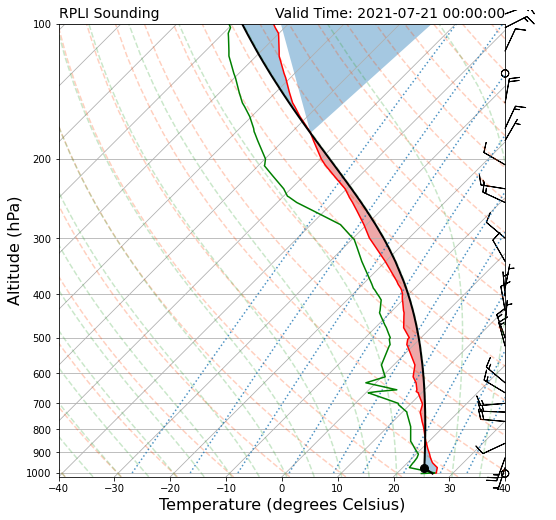

In [7]:
# Change default to be better for skew-T
fig = plt.figure(figsize=(8, 10))

# Initiate the skew-T plot type from MetPy class loaded earlier
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p[::3], u[::3], v[::3], y_clip_radius=0.03)

# Set some appropriate axes limits for x and y
skew.ax.set_xlim(-40, 40)
skew.ax.set_ylim(1020, 100)

# Add the relevant special lines to plot throughout the figure
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25, color='tab:green')
skew.plot_mixing_lines(pressure=np.arange(1000, 99, -20) * units.hPa,
                       linestyle='dotted', color='tab:blue')

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black',markersize=8)

# Plot the parcel profile as a black line
skew.plot(p, day_parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, day_parcel_prof)
skew.shade_cape(p, T, day_parcel_prof)

# Add some descriptive titles
plt.title('{} Sounding'.format(station), loc='left',fontsize=14)
plt.title('Valid Time: {}'.format(day_dt), loc='right',fontsize=14)

# Add axis labels
plt.xlabel('Temperature (degrees Celsius)',fontsize=16)
plt.ylabel('Altitude (hPa)',fontsize=16)

plt.show()

This Skew-T diagram shows the lifting condensation level (LCL) as a black dot, and the temperature profile of the air parcel as it ascends after reaching the LCL as a black curve. The diagram also includes the shaded area encompassed by the CAPE (in red) and CIN (in blue).

The area of the CIN at the lower altitude is very small indicating that very little to no temperature inversion occured.

## Comparing day and night soundings

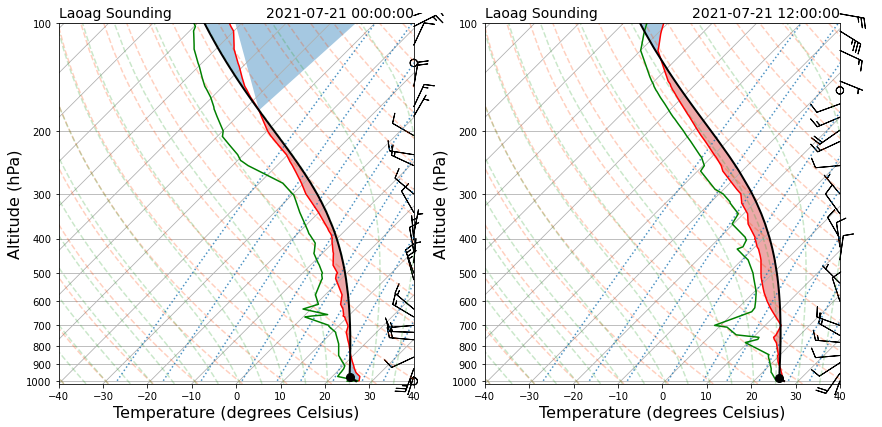

In [8]:
fig = plt.figure(figsize=(14,10))

# Plot Skew-T diagram for January 15
skew = SkewT(fig,subplot=[1,2,1], rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(day_data['pressure'], day_data['temperature'], 'r')
skew.plot(day_data['pressure'], day_data['dewpoint'], 'g')
skew.plot_barbs(day_data['pressure'][::3], day_data['u_wind'][::3], day_data['v_wind'][::3], y_clip_radius=0.03)

# Set some appropriate axes limits for x and y
skew.ax.set_xlim(-40, 40)
skew.ax.set_ylim(1020, 100)

# Add the relevant special lines to plot throughout the figure
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25, color='tab:green')
skew.plot_mixing_lines(pressure=np.arange(1000, 99, -20) * units.hPa,
                       linestyle='dotted', color='tab:blue')

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black',markersize=8)

# Plot the parcel profile as a black line
skew.plot(p, day_parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, day_parcel_prof)
skew.shade_cape(p, T, day_parcel_prof)

# Add some descriptive titles
plt.title('Laoag Sounding', loc='left',fontsize=14)
plt.title(format(day_dt), loc='right',fontsize=14)

# Add axis labels
plt.xlabel('Temperature (degrees Celsius)',fontsize=16)
plt.ylabel('Altitude (hPa)',fontsize=16)

# Plot Skew-T diagram for July 15
skew = SkewT(fig,subplot=[1,2,2], rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(night_data['pressure'], night_data['temperature'], 'r')
skew.plot(night_data['pressure'], night_data['dewpoint'], 'g')
skew.plot_barbs(night_data['pressure'][::3], night_data['u_wind'][::3], night_data['v_wind'][::3], y_clip_radius=0.03)

# Set some appropriate axes limits for x and y
skew.ax.set_xlim(-40, 40)
skew.ax.set_ylim(1020, 100)

# Add the relevant special lines to plot throughout the figure
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25, color='tab:green')
skew.plot_mixing_lines(pressure=np.arange(1000, 99, -20) * units.hPa,
                       linestyle='dotted', color='tab:blue')

# Plot LCL temperature as black dot
skew.plot(night_lcl_pressure, night_lcl_temperature, 'ko', markerfacecolor='black',markersize=8)

# Plot the parcel profile as a black line
skew.plot(night_data['pressure'], night_parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(night_data['pressure'], night_data['temperature'], night_parcel_prof)
skew.shade_cape(night_data['pressure'], night_data['temperature'], night_parcel_prof)

# Add some descriptive titles
plt.title('Laoag Sounding', loc='left',fontsize=14)
plt.title(format(night_dt), loc='right',fontsize=14)

# Add axis labels
plt.xlabel('Temperature (degrees Celsius)',fontsize=16)
plt.ylabel('Altitude (hPa)',fontsize=16)

plt.show()

The Skew-T diagrams compare the soundings during the morning and evening. The temperature lines more or less look alike. Most of the differences in the soundings are visible in the measurements of dewpoint temperature and the CAPE. 

It seems that there is a probable temperature inversion during the evening, but very thin. The dewpoint depression also tends to be lower during the evening at higher altitudes than in the morning. The CAPE area during the evening is bigger than in the morning, which suggests that evenings are more unstable than mornings. 

### Obtain sounding data for January 15, 2020 00Z and July 15, 2020 00Z in Laoag

In [9]:
# January 15, 2020 00Z
jan_dt = datetime(2020, 1, 15, 0)

# July 15, 2020 00Z
jul_dt = datetime(2020, 7, 15, 0)

### Obtain sounding data for Laoag in January and July 15 2020 00Z

In [10]:
# Read remote sounding data based on time (dt) and station
jan_df = WyomingUpperAir.request_data(jan_dt, station)
jul_df = WyomingUpperAir.request_data(jul_dt, station)

# Create dictionary of united arrays
jan_data = pandas_dataframe_to_unit_arrays(jan_df)
jul_data = pandas_dataframe_to_unit_arrays(jul_df)

### Calculate LCL and parcel profile for January and July

In [11]:
# Calculate pressure and temperature at LCL
jan_lcl_pressure, jan_lcl_temperature = mpcalc.lcl(jan_data['pressure'][0], jan_data['temperature'][0],jan_data['dewpoint'][0])
jul_lcl_pressure, jul_lcl_temperature = mpcalc.lcl(jul_data['pressure'][0], jul_data['temperature'][0],jul_data['dewpoint'][0])


# Calculate the parcel profile
jan_parcel_prof = mpcalc.parcel_profile(jan_data['pressure'], jan_data['temperature'][0],jan_data['dewpoint'][0]).to('degC')
jul_parcel_prof = mpcalc.parcel_profile(jul_data['pressure'], jul_data['temperature'][0],jul_data['dewpoint'][0]).to('degC')

## Plot Skew-T diagram for Laoag in January and July 8AM PHT

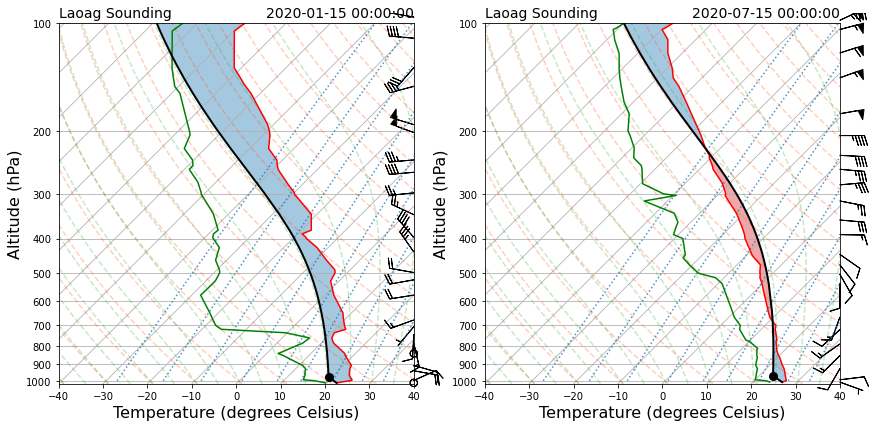

In [12]:
fig = plt.figure(figsize=(14,10))

# Plot Skew-T diagram for January 15
skew = SkewT(fig,subplot=[1,2,1], rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(jan_data['pressure'], jan_data['temperature'], 'r')
skew.plot(jan_data['pressure'], jan_data['dewpoint'], 'g')
skew.plot_barbs(jan_data['pressure'][::3], jan_data['u_wind'][::3], jan_data['v_wind'][::3], y_clip_radius=0.03)

# Set some appropriate axes limits for x and y
skew.ax.set_xlim(-40, 40)
skew.ax.set_ylim(1020, 100)

# Add the relevant special lines to plot throughout the figure
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25, color='tab:green')
skew.plot_mixing_lines(pressure=np.arange(1000, 99, -20) * units.hPa,
                       linestyle='dotted', color='tab:blue')

# Plot LCL temperature as black dot
skew.plot(jan_lcl_pressure, jan_lcl_temperature, 'ko', markerfacecolor='black',markersize=8)

# Plot the parcel profile as a black line
skew.plot(jan_data['pressure'], jan_parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(jan_data['pressure'], jan_data['temperature'], jan_parcel_prof)
skew.shade_cape(jan_data['pressure'], jan_data['temperature'], jan_parcel_prof)

# Add some descriptive titles
plt.title('Laoag Sounding', loc='left',fontsize=14)
plt.title(format(jan_dt), loc='right',fontsize=14)

# Add axis labels
plt.xlabel('Temperature (degrees Celsius)',fontsize=16)
plt.ylabel('Altitude (hPa)',fontsize=16)

# Plot Skew-T diagram for July 15
skew = SkewT(fig,subplot=[1,2,2], rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(jul_data['pressure'], jul_data['temperature'], 'r')
skew.plot(jul_data['pressure'], jul_data['dewpoint'], 'g')
skew.plot_barbs(jul_data['pressure'][::3], jul_data['u_wind'][::3], jul_data['v_wind'][::3], y_clip_radius=0.03)

# Set some appropriate axes limits for x and y
skew.ax.set_xlim(-40, 40)
skew.ax.set_ylim(1020, 100)

# Add the relevant special lines to plot throughout the figure
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25, color='tab:green')
skew.plot_mixing_lines(pressure=np.arange(1000, 99, -20) * units.hPa,
                       linestyle='dotted', color='tab:blue')

# Plot LCL temperature as black dot
skew.plot(jul_lcl_pressure, jul_lcl_temperature, 'ko', markerfacecolor='black',markersize=8)

# Plot the parcel profile as a black line
skew.plot(jul_data['pressure'], jul_parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(jul_data['pressure'], jul_data['temperature'], jul_parcel_prof)
skew.shade_cape(jul_data['pressure'], jul_data['temperature'], jul_parcel_prof)

# Add some descriptive titles
plt.title('Laoag Sounding', loc='left',fontsize=14)
plt.title(format(jul_dt), loc='right',fontsize=14)

# Add axis labels
plt.xlabel('Temperature (degrees Celsius)',fontsize=16)
plt.ylabel('Altitude (hPa)',fontsize=16)

plt.show()

The temperature profile during January and July more or less look alike, with a few minor temperature inversions with increasing altitude in January. The dew point temperatures between the two show a greater difference. At around 700 hPa, the dewpoint depression during January begin to increase, indicating dryer conditions. Since the dewpoint depression increases, the relative humidity consequently decreases, supporting the initial observation that January is dryer than July. 

From the shaded areas of CAPE and CIN, we see that January 15's CAPE is essentially zero with a big CIN area, indicating a very stable atmosphere with very little chances for convective storms. 

## Comparing diurnal cycle of CAPE (instability score) between January and July

In [13]:
jan_day_cane = []
jul_day_cane = []

jan_night_cane = []
jul_night_cane = []

jan_day_lcl = []
jul_day_lcl = []

for i in range(1,32):
    jan_day_dt = datetime(2020, 1, i, 0)
    jul_day_dt = datetime(2020, 7, i, 0) 
    
    jan_night_dt = datetime(2020, 1, i, 12)
    jul_night_dt = datetime(2020, 7, i, 12) 
    
    try:
        jan_day_data = pandas_dataframe_to_unit_arrays(WyomingUpperAir.request_data(jan_day_dt, station))
        jan_day_cane.append(mpcalc.cape_cin(jan_day_data['pressure'], jan_day_data['temperature'], jan_day_data['dewpoint'], \
                    mpcalc.parcel_profile(jan_day_data['pressure'], jan_day_data['temperature'][0], \
                                          jan_day_data['dewpoint'][0]).to('degC'))[0].magnitude)
        jan_day_lcl.append(mpcalc.lcl(jan_day_data['pressure'][0], jan_day_data['temperature'][0], \
                                      jan_day_data['dewpoint'][0])[0].magnitude)
    except Exception as e:
        print(e)
        
    try:
        jul_day_data = pandas_dataframe_to_unit_arrays(WyomingUpperAir.request_data(jul_day_dt, station))
        jul_day_cane.append(mpcalc.cape_cin(jul_day_data['pressure'], jul_day_data['temperature'], jul_day_data['dewpoint'], \
                        mpcalc.parcel_profile(jul_day_data['pressure'], jul_day_data['temperature'][0], \
                                              jul_day_data['dewpoint'][0]).to('degC'))[0].magnitude)
        jul_day_lcl.append(mpcalc.lcl(jul_day_data['pressure'][0], jul_day_data['temperature'][0], \
                                      jul_day_data['dewpoint'][0])[0].magnitude)
    except Exception as e:
        print(e)
    
    try:
        jan_night_data = pandas_dataframe_to_unit_arrays(WyomingUpperAir.request_data(jan_night_dt, station))
        jan_night_cane.append(mpcalc.cape_cin(jan_night_data['pressure'], jan_night_data['temperature'], jan_night_data['dewpoint'], \
                        mpcalc.parcel_profile(jan_night_data['pressure'], jan_night_data['temperature'][0], \
                                              jan_night_data['dewpoint'][0]).to('degC'))[0].magnitude)
    except Exception as e:
        print(e)

    try:
        jul_night_data = pandas_dataframe_to_unit_arrays(WyomingUpperAir.request_data(jul_night_dt, station))
        jul_night_cane.append(mpcalc.cape_cin(jul_night_data['pressure'], jul_night_data['temperature'], jul_night_data['dewpoint'], \
                        mpcalc.parcel_profile(jul_night_data['pressure'], jul_night_data['temperature'][0], \
                                              jul_night_data['dewpoint'][0]).to('degC'))[0].magnitude)
    except Exception as e:
        print(e)
        
    print("Processing day:",i)

No data available for 2020-07-01 00Z for station RPLI.
No data available for 2020-07-01 12Z for station RPLI.
Processing day: 1
Processing day: 2
Processing day: 3
Processing day: 4
Processing day: 5
Processing day: 6
Processing day: 7
Processing day: 8
Processing day: 9
Processing day: 10
Processing day: 11
Processing day: 12
Processing day: 13
Processing day: 14
Processing day: 15
Processing day: 16
Processing day: 17
Processing day: 18
Processing day: 19
Processing day: 20
Processing day: 21
Processing day: 22
Processing day: 23
Processing day: 24
Processing day: 25
Processing day: 26
Processing day: 27
Processing day: 28
Processing day: 29
Processing day: 30
Processing day: 31


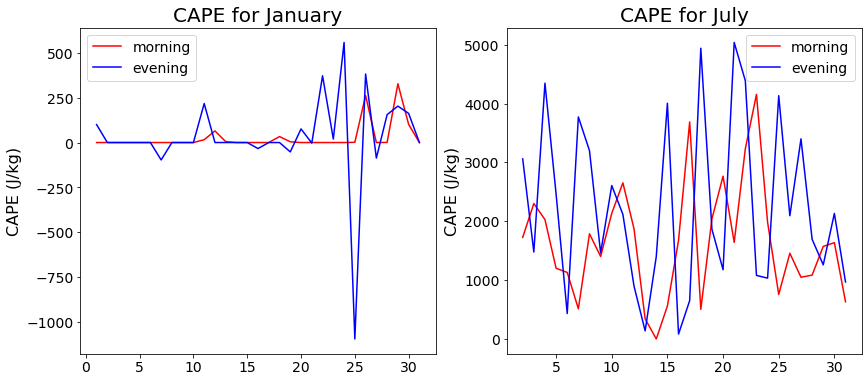

In [14]:
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.title("CAPE for January",fontsize=20)
plt.plot(np.arange(1,32),jan_day_cane,label="morning",color='red')
plt.plot(np.arange(1,32),jan_night_cane,label="evening",color='blue')
plt.legend(loc='best',fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('CAPE (J/kg)',fontsize=16)

plt.subplot(122)
plt.title("CAPE for July",fontsize=20)
plt.plot(np.arange(2,32),jul_day_cane,label="morning",color='red')
plt.plot(np.arange(2,32),jul_night_cane,label="evening",color='blue')
plt.legend(loc='best',fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('CAPE (J/kg)',fontsize=16)

plt.show()

In comparing the CAPE values for January and July, we can see that the atmosphere tends to be more unstable during July, while remaining decently stable in January. I'm not sure what happened in one of the calculations for CAPE in january with a very high negative value. The CAPE is supposedly the positive area, so the negative value is a little concerning. 

Based on the diurnal cycle, we can also see that evenings tend to be more unstable than mornings for both months.

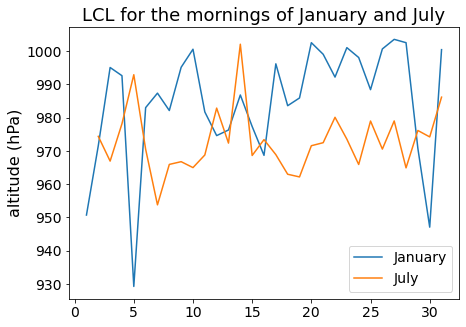

In [15]:
plt.figure(figsize=(7,5))

plt.title("LCL for the mornings of January and July",fontsize=18)
plt.plot(np.arange(1,32),jan_day_lcl,label="January")
plt.plot(np.arange(2,32),jul_day_lcl,label="July")

plt.ylabel("altitude (hPa)",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc='best',fontsize=14)
plt.show()

Visually, there are no discernible differences for the LCL of January and July. However, it seems that generally January's LCL is found in lower altitudes nearer to the surface than July.